In [39]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel, LognormalModel
from lmfit import Parameters, fit_report, minimize


add_data_manually = False  # to add latest info not in the database yet
countries = ['US']
Yaxis = 'Deaths' # Cases or Deaths

DataSource = 'JohnHopkins'

if DataSource == 'JohnHopkins':
    fname = 'time_series_covid19_confirmed_global.csv'

    if os.path.exists(fname):
        os.remove(fname)

    ddir = 'data/'
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    #'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    ff = wget.download(url)
    fd = wget.download(url_deaths)
    print (ff)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

    dd = pd.read_csv(ff)
    deaths = pd.read_csv(fd)

else:
    fname = 'full_data.csv'
    if os.path.exists(fname):
        os.remove(fname)
    
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    ff = wget.download(url)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'
    dd = pd.read_csv(ff, parse_dates = ['date'])
    
    
## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



time_series_covid19_confirmed_global.csv


In [40]:
dd['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

    Province/State Country/Region      Lat     Long  1/22/20  1/23/20  \
225            NaN             US  37.0902 -95.7129        1        1   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  3/29/20  3/30/20  3/31/20  \
225        2        2        5        5  ...   140909   161837   188172   

     4/1/20  4/2/20  4/3/20  4/4/20  4/5/20  4/6/20  4/7/20  
225  213372  243616  275586  308850  337072  366667  396223  

[1 rows x 81 columns]
US 0
US 90
Index(['23/01', '24/01', '25/01', '26/01', '27/01', '28/01', '29/01', '30/01',
       '31/01', '01/02', '02/02', '03/02', '04/02', '05/02', '06/02', '07/02',
       '08/02', '09/02', '10/02', '11/02', '12/02', '13/02', '14/02', '15/02',
       '16/02', '17/02', '18/02', '19/02', '20/02', '21/02', '22/02', '23/02',
       '24/02', '25/02', '26/02', '27/02', '28/02', '29/02', '01/03', '02/03',
       '03/03', '04/03', '05/03', '06/03', '07/03', '08/03', '09/03', '10/03',
       '11/03', '12/03', '13/03', '14/03', '15/03', '16/03', '17/03', 

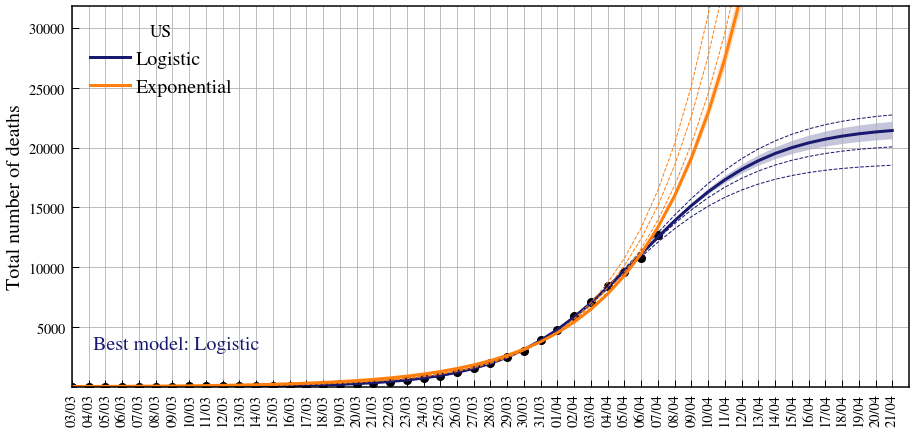

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from datetime import Timedelta 
import datetime
from dateutil import parser

timedelta = pd.Timedelta('1 days')

ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'), 
        'Exponential': ExponentialModel() } #,
#        'erf': StepModel(form='erf'),
#        'Arctan': StepModel(form='atan'), 
#        '7th deg. Polynomial': PolynomialModel(degree=7)}
        
        
        

colors = ['midnightblue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,ncountries*7))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

countryvar = 'location' if DataSource == 'OurWorldData' else 'Country/Region'
covid_dict = {}

for icc,country in enumerate(countries):

    sel = dd[countryvar] == country
    dc = dd.loc[sel]
    dcd = deaths.loc[deaths[countryvar] == country]
    print (dc)
    cols = list(dc.columns)
    dates = cols[4:] if DataSource == 'JohnHopkins' else dc['date'].reset_index(drop=True)

    if country == 'xNew Zealand':
        dates = dates - timedelta
    
    if DataSource == 'JohnHopkins':
        nn = []
        nd = []
        for i in dates:
            nn.append(dc[i].to_numpy()[0])
            nd.append(dcd[i].to_numpy()[0])
    else:
        nn      = dc['total_cases'].reset_index(drop=True).to_numpy()
        ndeaths = dc['total_deaths'].reset_index(drop=True).to_numpy()
        nnew    = dc['new_cases'].reset_index(drop=True).to_numpy()
        
    xstart = 0
    
    for ii, inn in enumerate(list(nn)):
        if inn > 1:
            xstart = ii-1 if ii > 1 else 0
            break
#    import pdb ; pdb.set_trace()        
    nn = nn[xstart:]
    nd = nd[xstart:]
    if DataSource != 'JohnHopkins':
        ndeaths  = ndeaths[xstart:]
        nnew     = nnew[xstart:]
        
    #print (dates.iloc[xstart], xstart)
    if DataSource != 'JohnHopkins':
        dates = dates.iloc[xstart:].reset_index(drop=True)
    else:
        dates = cols[4 + xstart:]
        dates = [parser.parse(x) for x in dates]
    
    # ensuring data completeness
    dates_all = pd.date_range(start=dates[0], end=dates[-1])
    ntotal      = [] #np.zeros(len(dates_all))
    ntot_deaths = []
    ntot_new    = []
    
    
    iid = 0
    for ixx, idate in enumerate(dates_all):
        if dates[iid] == idate:
            ntotal.append(nn[iid])
            ntot_deaths.append(nd[iid])
            #ntot_new.append(nnew[iid])
            iid += 1
        else:
            ntotal.append(ntotal[ixx-1])
            ntot_deaths.append(nd[ixx-1])
            #ntot_new.append(ntot_new[ixx-1])
            
    
    #import pdb ; pdb.set_trace()
    
    if add_data_manually:
        if country == 'Chile':
            ntotal.append(2738)
            ntot_deaths.append(ntot_deaths[-1])
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates[0], periods = len(dates_all)+1)
        if country == 'New Zealand':
            ntotal.append(1210)
            ntot_deaths.append(ntot_deaths[-1])
            #ntotal[-2] = 797-89
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            #ntotal.append(589)
            #ntot_deaths.append(0)
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates[0], periods = len(dates_all)+1)
    
    
    nn = ntotal if Yaxis == 'Cases' else ntot_deaths
    dates = dates_all
    xstart = 0
    
    covid_dict[country] = {'dates': dates,
                         'ntotal': ntotal,
                         'ntot_deaths': ntot_deaths,
                          'ntot_new':ntot_new
                         }
    
    print (country, xstart)
    ndata = len(nn)
    nn = np.array(nn)
    xx = np.arange(0,ndata)
    xxx = np.arange(0,ndata+14)
    nper = len(xxx)
    print (country, nper)
    xxxx = np.arange(0,ndata+14)# if nper < 100 else 2)
    datesxxx = pd.date_range(start=dates[0], periods=nper).strftime('%d/%m')
    
    #import pdb ; pdb.set_trace()    
    
    print (datesxxx)
    
    if ncountries > 1:
        ax = axs[icc]
    else:
        ax = axs

    
    ax.set_xticks(xxxx)
    ax.set_xticklabels(datesxxx[xxxx], rotation='vertical')
    ax.plot(xx,nn,'ko',markersize=8)
  #  ax.set_yscale('log')

    icol = 0 
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > 10)[0]
    bics = []
    mn = []
    
    for mname, model in models.items():
       
        pars0 = model.guess(nn[ixx], x=xx[ixx])
        out = model.fit(nn[ixx], pars0, x=xx[ixx])
        print ()
        print (mname)
        print(fit_report(out))
        print()

        pars = out.params
        bics.append(out.bic)
        mn.append(mname)
 
        dely = out.eval_uncertainty(x=xxx)
        y =  out.eval(pars,x=xxx)        
        ax.plot(xxx,y, '-', label=f'{mname}', color=colors[icol],linewidth=3)
        ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
        
        
        if mname == 'Exponential' or mname == 'Logistic' or mname == 'LogNormal':
            for prev_fit in [-1,-2,-3]:
                print (prev_fit)
                pars0 = model.guess(nn[ixx[:prev_fit]], x=xx[ixx[:prev_fit]])
                out = model.fit(nn[ixx[:prev_fit]], pars0, x=xx[ixx[:prev_fit]])
                pars = out.params
                #bics.append(out.bic)
                #mn.append(mname)

                #dely = out.eval_uncertainty(x=xxx)
                y =  out.eval(pars,x=xxx)        
                ax.plot(xxx,y, '--', color=colors[icol],linewidth=1)
                #ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
                #icol += 1
        
        icol += 1
        
        
        
       # print (mname, country, y[len(xx) + 11], bics[-1])
    
    bic = np.argmin(bics)
    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
           transform=ax.transAxes, color= colors[bic])


    ax.set_xlim([40,ndata + 14])
    ax.set_ylim([0.1,np.min([2000000, np.max(nn)*2.5])])
    ax.ticklabel_format(axis='y', style='sci',useMathText=True, scilimits=(0,6))
    ylabel = 'cases' if Yaxis == 'Cases' else 'deaths'
    ax.set_ylabel(f'Total number of {ylabel}',fontsize=20)
    
    ax.grid()
    

    if country == 'New Zealand':
        
        alert_colors = plt.cm.Blues(np.linspace(0.3,0.7, 3))
        alert_dates = ['21/03','23/03','26/03']
        ix_alert = []
        for alert in alert_dates:
            sel = np.where(alert == datesxxx)[0]
            print (sel)
            ix_alert.append(sel[0])
        
#        ax.fill_between([ix_alert[0], ix_alert[1]], [0,0],[1e4,1e4], facecolor=alert_colors[0],alpha=0.3,label='Alert level 2')
#        ax.fill_between([ix_alert[1], ix_alert[2]], [0,0],[1e4,1e4], facecolor=alert_colors[1],alpha=0.4,label='Alert level 3')
        ax.fill_between([ix_alert[2], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.3,label='Alert level 4')
    
    if country == 'Italy':
        alert_colors = plt.cm.Reds(np.linspace(0.3,0.7, 3))
        alert_dates = ['09/03']#,'23/03','26/03']
        ix_alert = []
        for alert in alert_dates:
            sel = np.where(alert == datesxxx)[0]
            print (sel)
            ix_alert.append(sel[0])
        
        ax.fill_between([ix_alert[0], xx[-2]], [0,0],[1e6,1e6], facecolor=alert_colors[-1],alpha=0.3,label='Quarantine')
      #  ax.fill_between([ix_alert[1], ix_alert[2]], [0,0],[1e4,1e4], facecolor=alert_colors[1],alpha=0.4,label='Alert level 3')
      #  ax.fill_between([ix_alert[2], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.4,label='Alert level 4')

    
    ax.legend(title=country, fontsize=20,loc='upper left')
plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)

In [42]:
def figures_to_html(figs, filename="test2.html"):
    dashboard = open(filename, 'w')
    dashboard.write("<html><head><style>div {display: inline-block;}</style></head><body>" + "\n")
    for fig in figs:
        inner_html = fig.to_html(auto_play=False).split('<body>')[1].split('</body>')[0]
        dashboard.write(inner_html)
    dashboard.write("</body></html>" + "\n")

In [43]:
import plotly.graph_objects as go

animated_plot = True
allfigs = []

if animated_plot:

    for country, cdict in covid_dict.items():
    
        _yname = ['ntotal']
        _xname = ['dates']
        df = pd.DataFrame(cdict)

        for xname, yname in zip(_xname, _yname):

            colorvar = 'ntot_new'
            size  = 'ntot_new'
            temp  = 'dates'
            
            #weeks = list(np.arange(df[temp].iloc[0], df[temp].iloc[-1]))
            #weeks = df[temp].dt.strftime('%m/%d')
            weeks = list(np.arange(len(df[temp])))
            
            # make list of continents
            colorprops = df[colorvar].unique() + 1

            # make figure
            fig_dict = {
                "data": [],
                "layout": {},
                "frames": []
            }


            minx, maxx = np.min(weeks), np.max(weeks) #df[xname].iloc[0],  df[xname].iloc[-1]
            miny, maxy = df[yname].min(), df[yname].max()
            strdate = [x.strftime('%m/%d') for x in df[temp]]


            # fill in most of layout
            fig_dict["layout"]["xaxis"] = {"range": [minx,maxx], "title": xname}
            fig_dict["layout"]["yaxis"] = {"title": yname, "range": [miny,maxy]}
            fig_dict["layout"]["hovermode"] = "closest"
            fig_dict["layout"]["sliders"] = {
                "args": [
                    "transition", {
                        "duration": 400,
                        "easing": "cubic-in-out"
                    }
                ],
                "initialValue": strdate[0],
                "plotlycommand": "animate",
                "values": strdate,
                "visible": True
            }
            fig_dict["layout"]["updatemenus"] = [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 500, "redraw": False},
                                            "fromcurrent": True, "transition": {"duration": 300,
                                                                                "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.1,
                    "xanchor": "right",
                    "y": 0,
                    "yanchor": "top"
                }
            ]

            sliders_dict = {
                "active": 0,
                "yanchor": "top",
                "xanchor": "left",
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": temp+":",
                    "visible": True,
                    "xanchor": "right"
                },
                "transition": {"duration": 300, "easing": "cubic-in-out"},
                "pad": {"b": 10, "t": 50},
                "len": 0.9,
                "x": 0.1,
                "y": 0,
                "steps": []
            }

            # make data
            for color in colorprops:
                df_color  = df.loc[(df[colorvar] == color) & (df[temp] == df[temp].iloc[0])]

                data_dict = {
                    "x": list(df_color[xname].dt.strftime('%m/%d')),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text":  [f'{size}: {x+1}' for x in df_color[size]],
                    "marker": {
                        "sizemode": "area",
                        "sizeref": .01,
                        "size": list(df_color[size]+1)
                    },
                    "name": str(color)
                            }
                fig_dict["data"].append(data_dict)

            # make frames
            frame = {}
            frame['data'] = []
            for week in weeks:
                frame['name'] = strdate[week]
                for color in colorprops:
                    df_color  = df.iloc[week] #.loc[(np.array(df[colorvar]) == color)]# & (np.array(weeks) <= week)]
                    print (df_color)
                    data_dict = {
                    "x": list(df_color[xname].dt.strftime('%m/%d')),
                    "y": list(df_color[yname]),
                    "mode": "markers",
                    "text": [f'{size}: {x+1}' for x in df_color[size]],
                    "marker": {
                    "sizemode": "area",
                    "sizeref": .01,
                    "size": list(df_color[size]+1)
                    },
                    "name": str(color)
                    }
                    frame["data"].append(data_dict)

                fig_dict["frames"].append(frame)
                slider_step = {"args": [
                    [week],
                    {"frame": {"duration": 300, "redraw": False},
                     "mode": "immediate",
                     "transition": {"duration": 300}}
                ],
                    "label": strdate[week],
                    "method": "animate"}
                sliders_dict["steps"].append(slider_step)


            fig_dict["layout"]["sliders"] = [sliders_dict]

            fig = go.Figure(fig_dict)
            fig.update_layout(height=600, width=900, title=country)
            allfigs.append(fig)
    #fig.write_html('test.html', auto_open=True)
figures_to_html(allfigs, filename = 'animation.html')
print ('done')

ValueError: arrays must all be same length

In [ ]:
%debug

In [ ]:

d


